# Customer Segmentation and Income Analysis: Exploring iFood's Marketing Data

The ultimate goal of this project is to develop a simple model that can identify customers based on their characteristics. We will analyze wheter customer income is determined by educational level and other characteristics.

The data used corresponds to iFood, the leading food delivery application in Brazil. The company sells food in various categories and seeks to improve the performance of its marketing activities. The new commercial campaign, the sixth one, aims to sell a new gadget to the customer database.

A pilot campaign was conducted, involving 2,240 customers. These customers were randomly selected and contacted by phone for the acquisition of the gadget.

The dataset for this analysis is named "marketing.csv". The variables it contains are:

ID: Identification number

Year_Birth: Year of birth

Education: The educational level of the customer (factor with 5 levels)

Marital_Status: The marital status of the customer (factor with 8 levels)

Income: Customer's annual income

Kidhome: Number of children living with the customer

Teenhome: Number of teenagers living with the customer

Dt_Customer: Date the customer joined the company

Recency: Number of days since the last purchase

MntWines: Amount spent on wine in the last 2 years

MntFruits: Amount spent on fruit in the last 2 years

MntMeatProducts: Amount spent on meat in the last 2 years

MntFishProducts: Amount spent on fish in the last 2 years

MntSweetProducts: Amount spent on sweets in the last 2 years

MntGoldProds: Amount spent on "gold" products in the last 2 years

NumDealsPurchases: Number of purchases made with a discount

NumWebPurchases: Number of purchases made through the Web

NumCatalogPurchases: Number of purchases made using the catalog

NumStorePurchases: Number of purchases made directly in stores

NumWebVisitsMonth: Number of website visits in the last month

AcceptedCmp3: 1 if the customer accepted the offer in the 3rd campaign, 0 if not

AcceptedCmp4: 1 if the customer accepted the offer in the 4th campaign, 0 if not

AcceptedCmp5: 1 if the customer accepted the offer in the 5th campaign, 0 if not

AcceptedCmp1: 1 if the customer accepted the offer in the 1st campaign, 0 if not

AcceptedCmp2: 1 if the customer accepted the offer in the 2nd campaign, 0 if not

Complain: 1 if the customer made a complaint in the last year, 0 if not

Z_CostContact: Control variable (should be excluded from the analysis)

Z_Revenue: Control variable (should be excluded from the analysis)

Response: 1 if the customer accepted the offer in the last campaign, 0 if not


The original dataset is available at:
https://github.com/nailson/ifood-data-business-analyst-test/blob/master/ifood_df.csv

In [1]:
# Dependencies in this project
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from scipy import stats
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.stats.anova import anova_lm
import itertools
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

## Exploratory analysis and data preprocessing

We start by loading and checking the variables.

In [2]:
marketing = pd.read_csv("marketing.csv")

print(marketing.dtypes)

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object


Variable types are correct. Outliers are detected thoughout the Interquartile Range (IQR).
To apply the IQR, it is necessary to filter out the non-numeric variables.

In [3]:
num_cols = marketing.select_dtypes(include=['number'])
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1
outliers = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR))).sum()
print(outliers)

ID                       0
Year_Birth               3
Income                   8
Kidhome                  0
Teenhome                 0
Recency                  0
MntWines                35
MntFruits              227
MntMeatProducts        175
MntFishProducts        223
MntSweetProducts       248
MntGoldProds           207
NumDealsPurchases       86
NumWebPurchases          4
NumCatalogPurchases     23
NumStorePurchases        0
NumWebVisitsMonth        8
AcceptedCmp3           163
AcceptedCmp4           167
AcceptedCmp5           163
AcceptedCmp1           144
AcceptedCmp2            30
Complain                21
Z_CostContact            0
Z_Revenue                0
Response               334
dtype: int64


The main variables to focus on from this list are 'Year_Birth' and 'Income', as they are key values for developing the model. Moreover, any extreme value in either of these two variables could have a significant impact on the model's performance and accuracy.

An statistic summary will be shown for each of them. A boxplot will complement them.

In [4]:
print(marketing['Year_Birth'].describe())
print("")
print(marketing['Income'].describe())

count    2240.000000
mean     1968.805804
std        11.984069
min      1893.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
max      1996.000000
Name: Year_Birth, dtype: float64

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64


<Axes: >

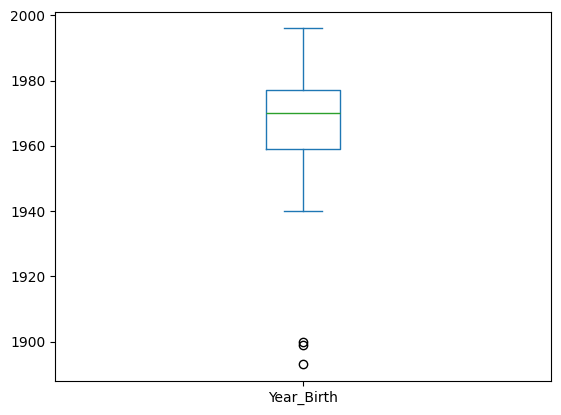

In [5]:
marketing['Year_Birth'].plot.box()

<Axes: >

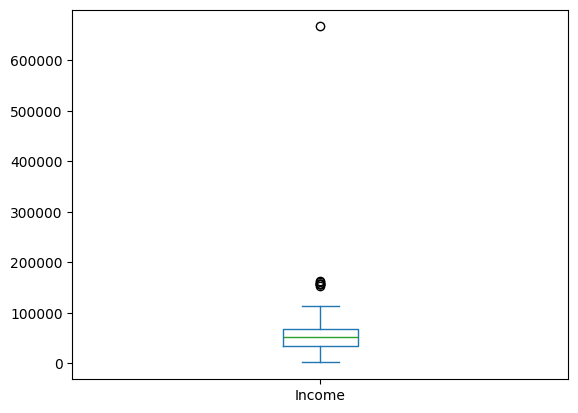

In [6]:
marketing['Income'].plot.box()

For this project, it is considered that the maximum age is 100 years, meaning that any register dating previous to that year will not be consideredd.
Similarly, in terms of income, the only outlier considered to be incorrect has been the most extreme one, as the pattern shows that it may have been an error (all the digits are 6).

Given that, the values considered as outliers will be converted into NA.

In [7]:
marketing.loc[marketing['Year_Birth'] < 1925, "Year_Birth"] = np.nan
marketing.loc[marketing['Income'] > 600000, "Income"] = np.nan

print(marketing['Year_Birth'].describe())
print("")
print(marketing['Income'].describe())

count    2237.000000
mean     1968.901654
std        11.701917
min      1940.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
max      1996.000000
Name: Year_Birth, dtype: float64

count      2215.000000
mean      51969.861400
std       21526.320095
min        1730.000000
25%       35284.000000
50%       51373.000000
75%       68487.000000
max      162397.000000
Name: Income, dtype: float64


The preprocessing stage ended with all variables in their adequate format, on outlier value from 'Income' transformed into NaN, and three outliers from 'Year_Birth' also tranformed into NaN, as they were determined as inconsistent.

## Managing NaN values

To handle missing values in 'Income', a predictive imputation approach using Gradient Boosting Regressor (GBR) was applied. This method leverages numerical spending data (variables 10 to 15) to estimate missing values while maintaining statistical integrity.

Originally, K-Nearest Neighbors (KNN) imputation with Gower distance was considered. This approach is well-suited for datasets with mixed data types (numerical and categorical), as Gower distance normalizes all features to a 0-1 scale, preventing variables with large ranges—such as 'Income'—from dominating the imputation process. This ensures that all predictors contribute equitably.

However, implementing Gower-based KNN imputation in Python posed several practical challenges, including:
- Computational inefficiency, especially with high-dimensional data.
- Scaling issues, as Gower distance is not natively supported in many Python imputation libraries.

As an alternative, KNN imputation using Euclidean distance was tested, but this approach introduced excessive bias due to the large numerical range of 'Income'. Since Euclidean distance does not normalize features, 'Income' had a disproportionate influence, leading to distorted imputations. This imbalance compromised statistical analyses such as F-tests and p-values, affecting the reliability of hypothesis testing.

To ensure accurate and unbiased imputations, Gradient Boosting Regressor (GBR) was selected due to its robust predictive capabilities in regression tasks. GBR offers several advantages:
- Captures complex, nonlinear relationships between 'Income' and spending behavior.
- Balances feature importance, preventing variables with large scales from overshadowing others.
- Delivers superior predictive accuracy compared to KNN, particularly when handling missing data.

For optimal performance, GBR was configured with 1000 estimators, a learning rate of 0.01, a max depth of 7.

These parameters ensure that the imputation process reflects realistic income patterns based on spending habits, leading to a statistically reliable dataset.

In [8]:
id = marketing[marketing["Income"].isna()].index
print(f"Number of NaN originally: {len(id)}")

Number of NaN originally: 25


In [9]:
cols_to_impute = ["Income", "MntWines", "MntFruits", "MntMeatProducts", 
                  "MntFishProducts", "MntSweetProducts", "MntGoldProds"]

ds = marketing[cols_to_impute].copy()


ds_known = ds.dropna(subset=["Income"])
ds_unknown = ds[ds["Income"].isna()]


X_train = ds_known.drop(columns=["Income"])
y_train = ds_known["Income"]
X_test = ds_unknown.drop(columns=["Income"])


imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
                                  max_depth=7, min_samples_split=2, random_state=42)
model.fit(X_train, y_train)


predicted_income = model.predict(X_test)


marketing.loc[marketing["Income"].isna(), "Income"] = predicted_income


print("NaN's after imputation:", marketing["Income"].isna().sum())


NaN's after imputation: 0


The previous code did the following actions:

1. Select variables: Extracts 'Income' and spending-related variables for imputation.

2. Separate data: Splits dataset into known (non-missing 'Income') and unknown (missing 'Income').

3. Define features & target: 'Income' is the target, and spending variables are the predictors.

4. Handle missing values: Imputes missing predictor values using the mean.

5. Train GBR model: Fits a Gradient Boosting Regressor to predict 'Income' based on spending patterns.

6. Predict missing values: Uses the trained model to estimate 'Income' for missing cases.

7. Update dataset: Replaces NaN values in 'Income' with predicted values.

8. Final check: Ensures no missing values remain.

For the 'Year_Birth' variable, the value used for the imputation will be the median for the observations having a 'Marital_Status' of 'Widow'.

Using the median "Year_Birth" of widowed individuals for imputation helps maintain statistical consistency, as widowed individuals tend to be older. This avoids bias from younger age distributions and provides a simple, effective method.

However, more advanced techniques like KNN imputation, regression, or probabilistic sampling could offer better accuracy depending on the dataset.

In [10]:
median_widowed_birth = marketing.loc[marketing["Marital_Status"] == 'Widow', 'Year_Birth'].median()

marketing.loc[marketing['Year_Birth'].isna(), 'Year_Birth'] = median_widowed_birth

print(marketing['Year_Birth'].isna().sum())

0


Once the 'Income' and 'Year_Birth' variables have been modified, the dataframe must be stored in a new dataframe object named 'markclean' without including any observation havin a NaN value for any variable present.

In [11]:
markclean = marketing.dropna()

print(f"Original dataset lenght: {len(marketing)}")

Original dataset lenght: 2240


No more observations having NaN are present in the dataframe.

## Descriptive Statistics

It is essential to assess whether the mean income is a representative measure of the overall income distribution. This involves analyzing the distribution's shape, central tendency, and variability to ensure that the mean accurately reflects the dataset.

Another crucial factor in this analysis is educational level, as it may significantly influence customer income. Therefore, it is important to examine the relationship between education and income to determine whether educational attainment serves as a predictor for income levels. This insight will help in understanding customer segmentation and its implications for marketing strategies.

A summary for the 'Income' variable is shown first.

In [12]:
markclean['Income'].describe()

count      2240.000000
mean      51970.466998
std       21592.278867
min        1730.000000
25%       35233.500000
50%       51369.000000
75%       68468.250000
max      162397.000000
Name: Income, dtype: float64

The median is also calculated.

In [13]:
print(markclean['Income'].median())

51369.0


The variation coefficient is used to analyze if the mean value for a variable is representative. When the coefficient is lower than 1, the mean value is set to be representative.

The mean income is a useful measure when the data is symmetrical and has low variability. However, if the coefficient of variation (CV) is high, it indicates high dispersion, meaning the mean may not accurately represent the dataset. In such cases, the median is a better alternative, as it is less affected by outliers and skewed distributions.

In [14]:
std_dev_income = markclean['Income'].std()
mean_income = markclean['Income'].mean()

cv_income = std_dev_income/mean_income

print(cv_income)

0.4154720962543203


A variation coefficient of 0.41 suggests that the mean income is a representative measure for the Income variable. However, to confirm this, it is important to analyze the distribution using a density plot and a Normal Q-Q plot.

These plots help assess whether the data follows a normal distribution, where the mean is a reliable central measure. If the distribution significantly deviates from normality, the mean may not be an appropriate representation of the dataset.

<Axes: ylabel='Density'>

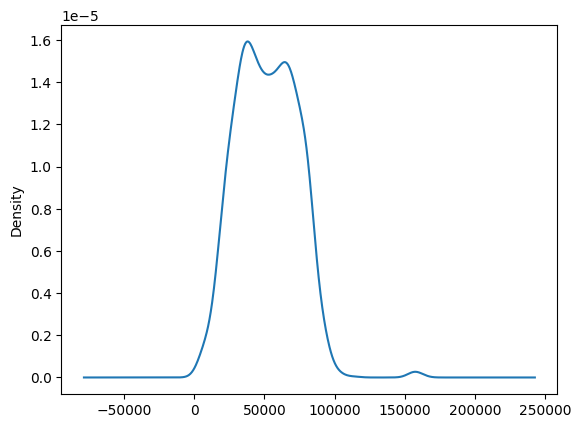

In [15]:
markclean['Income'].plot.density()

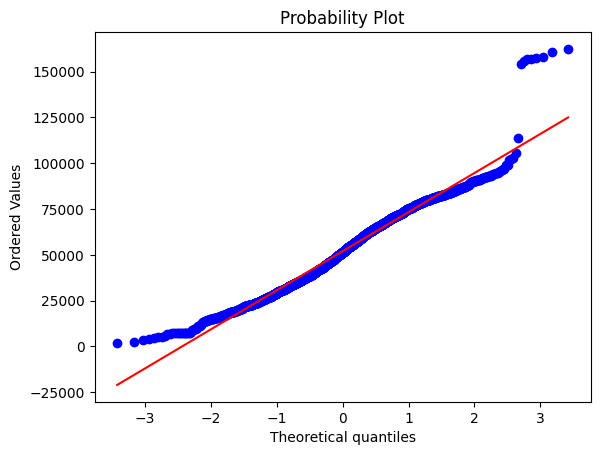

In [16]:
stats.probplot(markclean['Income'], dist = "norm", plot=plt) # 'dist=norm' -> Q-Q Plot compares 'Income' distr. to a normal theoretical distr.
plt.show()

The density plot shows a distribution with a slight asymmetry on the right side, while the q-q plot shows the shape of the distribution itself.

Both graphs indicate that 'Income' does not follow a normal distribution, but considering that both the median and the mean have a similar value while the variation coefficient is lower than 1, it means that the asymmetry is not very intense, meaning that the mean is a representative value. 

Regarding the 'Education' variable, the best way to check whether if the educational level and the income have a strong relationship will be by showing a summary per each level of education including the mean income, the amount of observations and the standard deviation for each of them.

Then, a set of 'boxplot' will help in terms of comparing them all.

The 'Education' variable must be transformed into categorical and ordered by level of education.

In [17]:
markclean['Education'] = pd.Categorical(markclean["Education"], categories=['PhD', 'Master', 'Graduation', '2n Cycle', 'Basic'],
                                                  ordered= True)

DS = markclean.groupby("Education", observed=False).agg(
    mwag=("Income", "mean"),
    n=("Income", "count"),
    sd=("Income", "std")
).reset_index()

print(DS)


    Education          mwag     n            sd
0         PhD  56024.507703   486  20559.787839
1      Master  53022.983241   370  20079.782702
2  Graduation  52107.690739  1127  21339.631326
3    2n Cycle  48007.517590   203  23285.023634
4       Basic  20306.259259    54   6235.066773


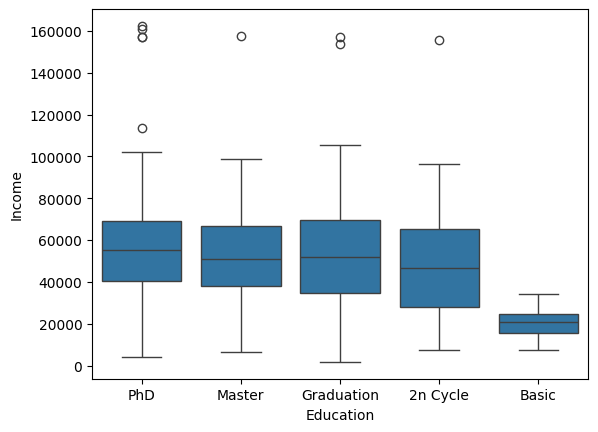

In [18]:
sns.boxplot(x='Education', y='Income', data=markclean)
plt.show()

According to both the descriptive table and the boxplots, it is clear that the income tends to be higher for those individuals with a higher eduaction level.

## Inferential Statistics

We have seen that the mean income value is a representative value for the income distribution, as well as the importance of the studies regarding the income amount but, can we accept that the average income of individuals without a university degree is lower than the individuals with a university degree?

At this point, an hypothesis test must be carried on. The answer will consider a 99% confidence level.

The first step is to define the null and alternative hypothesis:

· Null hypothesis (H₀): There is no difference in income between individuals with a university degree and those without one.

· Alternative hypothesis (H₁): There is a difference in income between the two groups. Since no prior assumption is made about which group has a higher income, this is a two-tailed test.


Given that the dataset consists of 2240 individuals, and the test is based on the mean income, we can apply the Central Limit Theorem (CLT). This means that, regardless of the original distribution of income, the sampling distribution of the mean follows a normal distribution when the sample size is sufficiently large. As a result, we can apply statistical methods that assume normality for the mean distribution.

To determine if there is a statistically significant difference between the average income of individuals with and without a university degree, a t-test for independent samples is used. A t-test is the best option for comparing two means when we have independent samples and can assume normality in the distribution of the mean value thanks to the Central Limit Theorem (CLT).

The standard t-test assumes that the variance of both samples is the same (homoscedasticity), but this has to be checked first.

An F test will be carried out, if it shows a similar variance between the income of both groups, then a t-test for similar variances will be applied, otherwise, a Welch t test would be the solution (corrected version of the standard t test).

In this case the hypothesis for the F-test are:

· Null hypothesis (H₀): The variances of both groups are equal (homoscedasticity holds).

· Alternative hypothesis (H₁): The variances of the two groups are different (heteroscedasticity is present).

In [19]:
I = markclean[(markclean["Education"] == "Basic") | (markclean["Education"] == "2n Cycle")].index
non_uni = markclean.loc[I, "Income"]
uni = markclean.loc[~markclean.index.isin(I), "Income"]

var1 = np.var(non_uni, ddof=1)
var2 = np.var(uni, ddof=1)

F_stat = var1 / var2
 
df1 = len(non_uni) - 1
df2 = len(uni) - 1
 
p_value = 2 * stats.f.sf(F_stat, df1, df2)
 
print('Degree of freedom 1:',df1)
print('Degree of freedom 2:',df2)
print("F-statistic:", F_stat)
print("p-value:", p_value)

alpha = 0.01
lower_CI = F_stat / stats.f.ppf(1 - alpha/2, df1, df2)
upper_CI = F_stat / stats.f.ppf(alpha/2, df1, df2)

print(f"Confidence interval of 99%: ({lower_CI}, {upper_CI})")


Degree of freedom 1: 256
Degree of freedom 2: 1982
F-statistic: 1.2816375541765075
p-value: 0.00594974418152361
Confidence interval of 99%: (1.0155615068626032, 1.6494994821605282)


Having a p-value below 0.01 indicates that we can reject the null hypothesis, which stated that the variances of both groups were equal. This means that, to determine whether the mean income differs between individuals with and without a university degree, it is necessary to apply a Welch t-test instead of the standard t-test.

The standard t-test calculates the t-statistic as the difference between both groups' mean values divided by the total standard deviation (sum of both groups' SD). In this case, the degrees of freedom are simply the number of observations per group minus the number of groups.

Welch's t-test adjusts the degrees of freedom according to the Welch-Satterthwaite formula, which accounts for differences in variance between groups, changing as a function of each group's dispersion.

Since we are testing whether individuals without a university degree earn less than those with a university degree, we apply a one-tailed t-test to the left. This means that we are only interested in the probability of the mean income of non-university individuals being significantly lower than that of university individuals. The one-tailed p-value is obtained directly from the cumulative distribution function (CDF) of the t-distribution, without multiplying by 2, as we are only considering one direction of the difference.

The resulting parameters will be calculated both manually and automatically to compare them.

In [20]:
def welch_ttest(non_uni, uni):
    n1, n2 = len(non_uni), len(uni)  
    m1, m2 = np.mean(non_uni), np.mean(uni)  
    s1, s2 = np.std(non_uni, ddof=1), np.std(uni, ddof=1)  

    # Degrees of Freedom according to Welch
    df = ((s1**2/n1 + s2**2/n2)**2) / ((s1**4 / (n1**2 * (n1 - 1))) + (s2**4 / (n2**2 * (n2 - 1))))

    # t-statistic
    s = np.sqrt(s1**2/n1 + s2**2/n2)
    t_stat = (m1 - m2) / s

    # p-value (one-tailed)
    p_value = t.cdf(t_stat, df)  

    return {"mean1": m1, "mean2": m2, "t": t_stat, "pvalue": p_value, "df": df}

# Manual t-test
result = welch_ttest(non_uni, uni)
print(result)

# Automatic t-test
t_stat, p_value = stats.ttest_ind(non_uni, uni, alternative="less", equal_var=False)

# Resultats
print("T-statistic:", t_stat)
print("p-value:", p_value)

{'mean1': np.float64(42187.01973047067), 'mean2': np.float64(53238.417551987615), 't': np.float64(-7.111018566544977), 'pvalue': np.float64(3.996164050595614e-12), 'df': np.float64(309.98275607128494)}
T-statistic: -7.111018566544977
p-value: 3.996164050595614e-12


Having a p-value clearly below 0.01 means that the null hypotesis has to be rejected.

It is safe to state that the mean income for those subjects with no university degree is lower than those who had a university certificate.

## Regression Model


Now that we confirmed that the clients without university degree have a lower mean income value, it is pertinent to investigate which variables exaplin the value for the income itself.

Considering that there are multiple variables and relationships, a multiple linear regression model is estimated. The designed predictors are:

- Year_Birth, Kidhome, Teenhome, Education, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumCatalogPurchases, NumStorePurchases and NumWebVisitsMonth.

The model's goal is focused on interpretability. Because of that, the linear regression model selected is the 'ols' model from statsmodel rather than 'LinearRegression' from sklearn, which is more focused on the predictions and large volumes of data (Machine Learning).

Moreover, the 'ols' model automatically converts categorical data into dummies with a simple command compared to the 'LinearRegression' model in which dummies have to be defined manually.

In [21]:
# Definir el model OLS
model = smf.ols("Income ~ C(Education, Treatment('Basic')) + Year_Birth + Kidhome + Teenhome + \
                MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + \
                MntGoldProds + NumDealsPurchases + NumCatalogPurchases + NumStorePurchases + NumWebVisitsMonth",
                data=markclean).fit()
print(model.summary())
p_value_f = model.f_pvalue
p_value_str = "< 0.05" if p_value_f < 0.05 else f"{p_value_f:.2e}"
print(f"P-value (F-statistic): {p_value_str}")

# Mostra coeficients amb p-values com en R
summary_df = model.summary2().tables[1]  # Agafa la taula de coeficients
summary_df = summary_df.rename(columns={"P>|t|": "p-value"})  # Renombrar la columna
print(summary_df[['Coef.', 'Std.Err.', 't', 'p-value']])  # Mostrar només les columnes importants


                            OLS Regression Results                            
Dep. Variable:                 Income   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     412.1
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        13:03:00   Log-Likelihood:                -23939.
No. Observations:                2240   AIC:                         4.791e+04
Df Residuals:                    2222   BIC:                         4.802e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

 The R-squared value represents the amount of variability of the predicted variable (Income) explained by the model. The adjusted R-squared value accounts for the number and quality of the predictors, meaning that if unnecessary predictors are included, the adjusted R-squared will be lower.

 Having an adjusted R-squared close to 0.76 and a p-value below 0.05, confirms that the model effectively explains 'Income' based on a set of significant predictors.

 When examining the predictors individually, most have a statistically significance effect on 'Income'. The column P>|t| represents the significance of each predictor.

 The model determines the coefficient for each predictor (change on 'Income' per unit of increment in the predictor), dividing this value by its standard error gives the t-statistic value. With the t-statistic distribution, it is possible to obtain the p-value for this predictor. Having a value below 0.05 (5%) means that the probability of obtaining such a extreme coefficient for this predictor under the null hypothesis where the predictor has no real effect over the output, is too low.

Lastly, the model output includes the statement:
"The condition number is large, 3.8e+05. This might indicate that there are strong multicollinearity or other numerical problems."
This suggests the presence of multicollinearity, meaning some predictors may be highly correlated, potentially affecting the reliability of the estimated coefficients.

To ensure that there are not problems with multicollinearity (high correlation between predictors), the Variance Inflation Factor (VIF) is calculated for each predictor.

The Variance Inflation Factor measures the correlation and strength of correlation between predictor variables in a regression model.

In [22]:
# Definir les variables predictors (sense la constant)
X = markclean[['Year_Birth', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 
               'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
               'MntGoldProds', 'NumDealsPurchases', 'NumCatalogPurchases', 
               'NumStorePurchases', 'NumWebVisitsMonth']]

# Afegir una constant per al model
X = sm.add_constant(X)

# Calcular el VIF per a cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

               Variable           VIF
0                 const  35186.601892
1            Year_Birth      1.241819
2               Kidhome      1.821302
3              Teenhome      1.554895
4              MntWines      2.379056
5             MntFruits      1.932648
6       MntMeatProducts      2.803841
7       MntFishProducts      2.079830
8      MntSweetProducts      1.845148
9          MntGoldProds      1.418940
10    NumDealsPurchases      1.602810
11  NumCatalogPurchases      2.944761
12    NumStorePurchases      2.249021
13    NumWebVisitsMonth      1.976352


According to the VIF values, as none of them is close or above 5, it does not show any problem related to multicollinearity.

Values close to 3, show a moderate correlation between predictors.

Multiple linear regression is valuable for determining the statistical significance of variables and assessing their impact on a dependent variable.

For categorical predictions (e.g., binary outcomes), logistic regression is the most suitable model. Unlike other regression methods, the logistic regression allows the prediction of probabilities rather than continuous values.

For example, to predict an employee's 'Income' based on professional characteristics (experience, education, etc.) or to estimate air pollution levels using various environmental factors, simple/multiple linear regression, Splines, and GAM are suitable options. Splines and GAM are more flexible when capturing non-linear relationships.

On the other hand, to predict the probability of a customer purchasing a product based on their purchase history, logistic regression is the best fit.

## Logistic regression

In this section, a logistic regression model is fitted in order to predict the probability of accepting the offer in the sixth campaign based on the number of discount purchases, the number of website visits in the last month, and whether the customer has accepted any offers in previous campaigns.

In [23]:
model_log = smf.logit("Response ~ NumDealsPurchases + NumWebVisitsMonth + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5 + AcceptedCmp1",
                      data=markclean).fit()

print(model_log.summary())

Optimization terminated successfully.
         Current function value: 0.344422
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 2240
Model:                          Logit   Df Residuals:                     2233
Method:                           MLE   Df Model:                            6
Date:                Sun, 23 Feb 2025   Pseudo R-squ.:                  0.1822
Time:                        13:03:00   Log-Likelihood:                -771.51
converged:                       True   LL-Null:                       -943.39
Covariance Type:            nonrobust   LLR p-value:                 3.352e-71
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.1556      0.196    -16.094      0.000      -3.540      -2.771
NumDeals

First, the Pseudo R-squared is similar to the R-squared in linear regression but adapted for logistic models. It measures how much better our model predicts the outcome compared to a baseline model with no predictors.

It is calculated as:

Pseudo R-squared = 1 - (LL_model / LL_null)

Where:

- LL_model: Log-likelihood of our fitted model (how well it predicts real values using predictor variables).
- LL_null: Log-likelihood of a baseline model with no predictors (only considering the overall probability of the outcome).

A higher log-likelihood (less negative) means the model makes better predictions. If Pseudo R² is closer to 1, it indicates that the predictors significantly improve the model.

In this case, Pseudo R² is around 0.18, meaning our model predicts 18% better than a baseline model.

Model significance (LLR p-value)
The LLR p-value tells us if at least one predictor significantly improves the model compared to a null model (one without predictors).

The Likelihood Ratio Test (LLR Test) is calculated as:

LLR = -2(LL_null - LL_model)

This value is then compared to a chi-squared distribution with the same degrees of freedom as the number of predictors.

In our case, the LLR p-value is 3.35e-71, an extremely small value, meaning that at least one predictor significantly improves the model.

Interpretation of predictors:
- Intercept (-3.1556, p < 0.05) → When all predictors are zero, the probability of accepting the offer (Response = 1) is very low.
- NumDealsPurchases (0.0786, p = 0.019) → As the number of purchases with a discount increases, the probability of accepting the offer slightly increases.
- NumWebVisitsMonth (0.0993, p = 0.001) → More website visits in the last month increase the probability of accepting the offer.
- AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1 (p < 0.05) → Accepting previous campaigns is the most relevant factor. Customers who accepted past offers are significantly more likely to accept the 6th offer.
- AcceptedCmp5 has the highest coefficient (2.0094), making it the most influential factor.

Conclusion:
The model is statistically significant, and the most important predictors are whether a customer has accepted previous campaigns. Visiting the website and purchasing with discounts also increase the probability of accepting the offer, but to a lesser extent.

To assess the performance of the model, a confusion matrix is computed.

First, predictions are generated as probabilities. These probabilities are then converted into binary outcomes (0 or 1) using 0.5 as the threshold. Finally, the confusion matrix compares the predicted values with the actual values, showing the number of true positives, false positives, true negatives, and false negatives produced by the model.

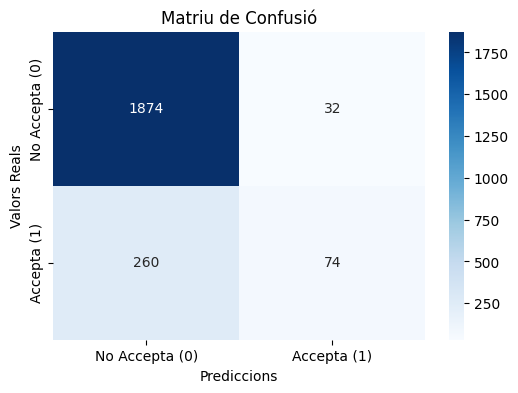


🔹 Classification Report:
                precision    recall  f1-score   support

No Accepta (0)       0.88      0.98      0.93      1906
   Accepta (1)       0.70      0.22      0.34       334

      accuracy                           0.87      2240
     macro avg       0.79      0.60      0.63      2240
  weighted avg       0.85      0.87      0.84      2240



In [24]:

# Fer prediccions amb el model (probabilitats)
y_prob = model_log.predict(markclean)  

# Convertir probabilitats en 0/1 segons un llindar de 0.5
y_pred = (y_prob >= 0.5).astype(int)  

# Obtenir la variable resposta real
y_true = markclean["Response"]

# Construir la matriu de confusió
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotejar la matriu amb etiquetes
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Accepta (0)", "Accepta (1)"], yticklabels=["No Accepta (0)", "Accepta (1)"])
plt.xlabel("Prediccions")
plt.ylabel("Valors Reals")
plt.title("Matriu de Confusió")
plt.show()

# Imprimir el classification report amb etiquetes clares
print("\n🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["No Accepta (0)", "Accepta (1)"]))



Precision (Positive Predictive Value)
Definition: Of the cases where the model predicts "acceptance" or "rejection," how many are actually correct?
- For rejections (0s), the model predicts 88% of the cases correctly.
- For acceptances (1s), the model predicts 70% of the cases correctly.

🔹 Interpretation:
This means that when the model predicts a customer will accept, it is correct 70% of the time. Similarly, when it predicts a rejection, it is correct 88% of the time.

Recall (True Positive Rate)
Definition: Of the actual "acceptances" and "rejections," how many did the model classify correctly?
- For rejections (0s), the model predicted 98% of them correctly.
- For acceptances (1s), the model predicted only 22% correctly.

🔹 Interpretation:
The model almost never misses a rejection, correctly identifying 98% of them. However, it fails to detect most acceptances, only predicting 22% of the real acceptances.


Final Analysis:
The model is highly conservative: it avoids predicting false acceptances (false positives), ensuring that when it does predict an acceptance, it's usually correct (70% precision).

However, this comes at a cost: it misses a lot of true acceptances (low recall of 22%), meaning it fails to identify many potential customers who actually accept the offer.
In simple terms: The model is good at saying "no," but not great at detecting "yes."

Based on the previously trained logistic regression model, we can predict how likely a customer is to accept the last offer given specific characteristics.

For this example, we want to estimate the probability of acceptance for a customer who:
- Has made 5 purchases with a discount
- Has visited the website 10 times
- Has accepted all previous campaign offers (Cmp1 to Cmp5)

To ensure accuracy, we will compute the probability in two ways:
- Manually, by applying the logistic regression formula step by step.
- Automatically, using the model's built-in prediction function.

In [25]:
# Coeficients del model
intercept = -3.1556
coef_num_deals = 0.0786
coef_web_visits = 0.0993
coef_cmp3 = 1.8558
coef_cmp4 = 0.6856
coef_cmp5 = 2.0094
coef_cmp1 = 1.5069

# Valors de l'observació a predir
num_deals = 5
num_web_visits = 10
accepted_cmp3 = 1
accepted_cmp4 = 1
accepted_cmp5 = 1
accepted_cmp1 = 1

# Càlcul de l'expressió lineal
linear_expression = (intercept +
                     coef_num_deals * num_deals +
                     coef_web_visits * num_web_visits +
                     coef_cmp3 * accepted_cmp3 +
                     coef_cmp4 * accepted_cmp4 +
                     coef_cmp5 * accepted_cmp5 +
                     coef_cmp1 * accepted_cmp1)

# Aplicar la funció sigmoide per obtenir la probabilitat
probability = np.exp(linear_expression) / (1 + np.exp(linear_expression))

print(f"Probabilitat d'acceptació: {probability:.4f}")


Probabilitat d'acceptació: 0.9865


In [26]:
# Crear un nou client amb les mateixes característiques
new_client = pd.DataFrame({
    "NumDealsPurchases": [5],
    "NumWebVisitsMonth": [10],
    "AcceptedCmp3": [1],
    "AcceptedCmp4": [1],
    "AcceptedCmp5": [1],
    "AcceptedCmp1": [1],
    "AcceptedCmp2": [1]  # Aquesta variable no estava a l'exemple anterior, però la mantenim
})

# Predir la probabilitat d'acceptació
predicted_prob = model_log.predict(sm.add_constant(new_client))  # Afegim la constant si és necessari
print(f"Probabilitat d'acceptació: {predicted_prob[0]:.4f}")


Probabilitat d'acceptació: 0.9864


## One-way ANOVA

One-way ANOVA is used to test differences among the mean values of three or more independent groups.

In this case, the goal is to compare Income across different educational levels to determine whether the variability in the dependent variable (Income) can be explained by one or more independent factors (education levels).

The analysis aims to answer two key questions:
- Are there any significant differences in mean income between education levels?
- If differences exist, between which education levels do they occur?

In previous steps, it was determined that having a university degree generally leads to a higher mean income compared to cases without university education. However, this comparison was made between only two groups: those with a degree and those without.

In this analysis, the goal is to visualize all education levels separately to identify specific differences between them.

A new boxplot, similar to the one presented in Section 2, is created. This time, all education levels are represented, along with the mean income for each group.

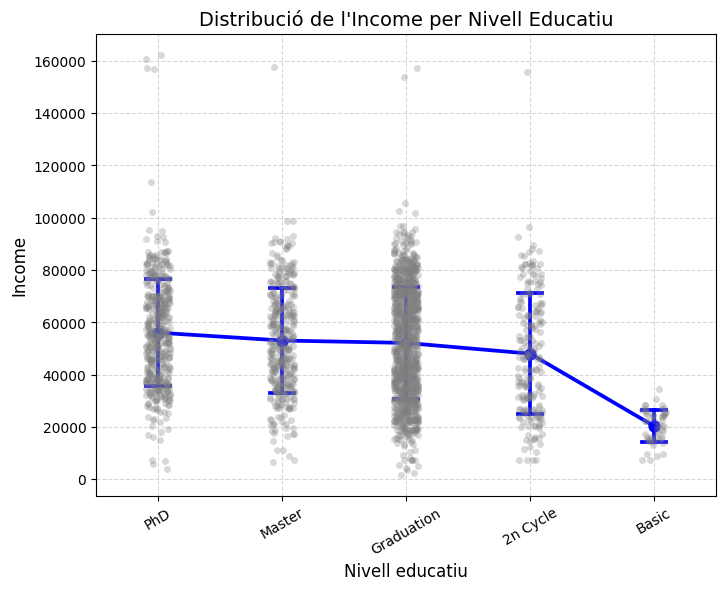

In [27]:
# Ordenar nivells educatius segons l'ordre desitjat
edu_order = ["PhD", "Master", "Graduation", "2n Cycle", "Basic"]

# Crear el gràfic amb mitjanes, intervals de confiança i dispersió (jitter)
plt.figure(figsize=(8, 6))
sns.pointplot(data=markclean, x="Education", y="Income", order=edu_order, 
              errorbar="sd", capsize=0.2, color="blue")  # Mostra la mitjana i desviació estàndard
sns.stripplot(data=markclean, x="Education", y="Income", order=edu_order, 
              jitter=True, color="gray", alpha=0.3)  # Mostra els punts dispersos

# Estil del gràfic
plt.xlabel("Nivell educatiu", fontsize=12)
plt.ylabel("Income", fontsize=12)
plt.title("Distribució de l'Income per Nivell Educatiu", fontsize=14)
plt.xticks(rotation=30)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In this case, the null hypothesis states that there are no differences in mean income across education levels, while the alternative hypothesis suggests that at least one group has a significantly different mean income.

Unlike the variance test performed earlier, which compared the variance between two groups, ANOVA extends this comparison to multiple groups. The F-statistic in ANOVA is obtained by comparing the variance between groups (explained variance) to the variance within groups (unexplained variance). The corresponding p-value will indicate whether the observed differences are statistically significant or could have occurred by chance.

In [28]:
# Ajustar el model de regressió
mod2 = smf.ols("Income ~ C(Education)", data=markclean).fit()

# Aplicar ANOVA
anova_results = anova_lm(mod2)

# Mostrar resultats
print(anova_results)

                  df        sum_sq       mean_sq          F        PR(>F)
C(Education)     4.0  6.574833e+10  1.643708e+10  37.558173  1.908221e-30
Residual      2235.0  9.781328e+11  4.376433e+08        NaN           NaN


The F-value, calculated by dividing the variance between groups by the within-group variance (aggregated), is 37.53, resulting in a p-value of 1.91e-30, which is much lower than 0.05.

In conclusion, the analyzed factor (Education Level) has a significant effect on the mean Income, leading to the rejection of the null hypothesis.

In order to measure how strongly the factor levels (Education) are related to 'Income', we calculate two metrics, the Estimate Effect for each level and the proportion of 'Income' variability explained by 'Education'.

The Estimated Effect for each level represents the difference between the mean income for all levels compared to each of the levels.

The proportion of income variabilitat (eta squared) is calculated by dividing the variance between education groups 'Income' and the Total Sum of Squares which is the sum of the variance within each group + variance between education groups.

A higher eta squared means that 'Education' (the factor, not any specific level) explains a larger proportion of income variability (meaning that the 'Education' factor is more important to understand the 'Income' values).

In [29]:
# Mitjana global d'Income
mu = markclean["Income"].mean()
print(f"Mitjana global d'Income: {mu:.2f}")

# Efecte estimat de cada nivell
education_means = markclean.groupby("Education")["Income"].mean()
effect_per_level = education_means - mu
print("\nEfecte estimat per nivell educatiu:\n", effect_per_level)

anova_table = sm.stats.anova_lm(mod2)

# Suma de quadrats entre grups (SSB) i total (SST)
SSB = anova_table['sum_sq'].iloc[0]
SST = sum(anova_table['sum_sq'])  

# Eta Squared
eta_squared = SSB / SST
print(f"η² (Eta Squared): {eta_squared:.4f}")


Mitjana global d'Income: 51970.47

Efecte estimat per nivell educatiu:
 Education
PhD            4054.040704
Master         1052.516243
Graduation      137.223741
2n Cycle      -3962.949409
Basic        -31664.207739
Name: Income, dtype: float64
η² (Eta Squared): 0.0630


C:\Users\roger\AppData\Local\Temp\ipykernel_19260\2375956546.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  education_means = markclean.groupby("Education")["Income"].mean()


The Estimated Effect for each level shows that there is a positive correlation between 'Income' and education, while the eta squared of 0.06 means that a 6% of the total variability of 'Income' depends on the variability observed between education groups (a 6% of Income's variability depends on the 'Education').

To evaluate whether One-Way ANOVA is appropriate for this case, we need to check if the residuals follow a normal distribution and if their variance is constant (homoscedasticity).

This is assessed visually using:
- A Q-Q plot to examine the distribution of residuals.
- A Residuals vs. Fitted plot to check for constant variance.

Additionally, we perform a Shapiro-Wilk test to statistically assess the normality of residuals, complementing the Q-Q plot.

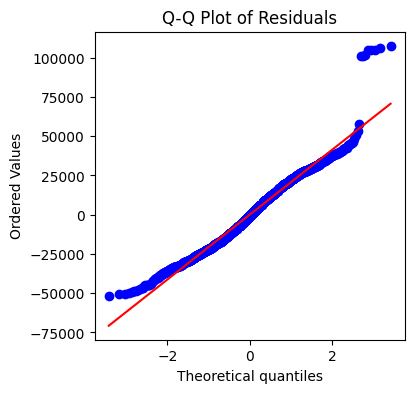

In [30]:
residuals = mod2.resid
fig, ax = plt.subplots(figsize=(4,4))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals")
plt.show()

In [31]:
# Calcular el test de Shapiro-Wilk per als residus del model OLS
stat, p_value = stats.shapiro(mod2.resid)

# Mostrar resultats
print(f"Estadístic de Shapiro-Wilk: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretació
if p_value > 0.05:
    print("No es rebutja H₀: Els residus semblen seguir una distribució normal.")
else:
    print("Es rebutja H₀: Els residus NO segueixen una distribució normal.")


Estadístic de Shapiro-Wilk: 0.9749
P-value: 0.0000
Es rebutja H₀: Els residus NO segueixen una distribució normal.


The right extreme from the normal Q-Q plot, shows a deviation in respect to the theoretical quantiles, meaning that the distribution is not normal.

Added to a Shapiro-Wilk test having a p-value below 0.05, the null hypothesis assuming normal distribution of the errors the can be rejected.

The residuals are the difference between real values and their predictions made by the model.

They are analyzed to check how well the model fits the data:

If they are randomly distributed with constant variance, the model is a good fit.
If they do not follow a normal distribution, it might indicate that ANOVA is not the best test. However, ANOVA is robust to mild deviations from normality, especially when the sample size is large.
To determine if ANOVA is still appropriate despite non-normal residuals, we must check the Residuals vs Fitted plot:

If this plot shows a pattern (e.g., a funnel shape or curve), it means heteroscedasticity (non-constant variance), and ANOVA may not be reliable.
If the variance remains roughly constant, ANOVA can still be applied despite non-normal residuals.
Thus, before discarding ANOVA due to non-normal residuals, we must ensure that the variance is homogeneous using the Residuals vs Fitted plot.

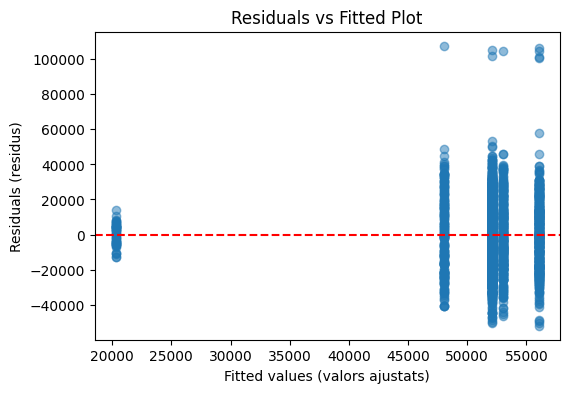

In [32]:
# Gràfic Residuals vs Fitted
plt.figure(figsize=(6,4))
plt.scatter(mod2.fittedvalues, mod2.resid, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Línia horitzontal a y=0
plt.xlabel("Fitted values (valors ajustats)")
plt.ylabel("Residuals (residus)")
plt.title("Residuals vs Fitted Plot")
plt.show()

The Residuals vs. Fitted Values plot reveals heteroscedasticity, meaning that the variance of the residuals is not constant across different fitted values. This violates the homogeneity of variance assumption required for ANOVA.

Although the ANOVA test resulted in a p-value below 0.05, indicating that at least one group mean differs significantly, the presence of heteroscedasticity suggests that the test results might not be reliable. ANOVA assumes both normality of residuals and homoscedasticity, and when these conditions are not met, Type I errors (false positives) become more likely, potentially leading us to incorrectly reject the null hypothesis.

Even though ANOVA is not fully appropriate in this case, the next step in the standard methodology is to perform pairwise comparisons using Bonferroni correction. This allows us to check which specific groups are significantly different from each other. Bonferroni is a conservative adjustment that reduces the likelihood of Type I errors when conducting multiple comparisons.

## Pairwise comparisons

To determine which education levels have significantly different mean incomes, pairwise comparisons are performed using the Bonferroni correction. This adjustment controls for multiple comparisons by dividing the significance level (𝛼) by the number of pairwise tests, reducing the risk of false positives (Type I errors).

In [33]:
# Suposem que `markclean` és un DataFrame amb Income i Education
groups = markclean.groupby("Education", observed=True)["Income"]

# Llista de comparacions per parelles
comparisons = list(itertools.combinations(groups.groups.keys(), 2))

# Aplicar test t per cada parella
p_values = []
for g1, g2 in comparisons:
    t_stat, p_val = ttest_ind(groups.get_group(g1), groups.get_group(g2), equal_var=False)
    p_values.append(p_val)

# Correcció de Bonferroni
p_adjusted = multipletests(p_values, method="bonferroni")[1]

# Resultats en un DataFrame
pairwise_results = pd.DataFrame(comparisons, columns=["Group 1", "Group 2"])
pairwise_results["p-value"] = p_values
pairwise_results["p-value (Bonferroni)"] = p_adjusted

# Mostrar resultats
print(pairwise_results)

      Group 1     Group 2       p-value  p-value (Bonferroni)
0         PhD      Master  3.231408e-02          3.231408e-01
1         PhD  Graduation  5.430361e-04          5.430361e-03
2         PhD    2n Cycle  2.643093e-05          2.643093e-04
3         PhD       Basic  8.234287e-76          8.234287e-75
4      Master  Graduation  4.541915e-01          1.000000e+00
5      Master    2n Cycle  1.008517e-02          1.008517e-01
6      Master       Basic  4.697753e-68          4.697753e-67
7  Graduation    2n Cycle  2.011621e-02          2.011621e-01
8  Graduation       Basic  1.447656e-59          1.447656e-58
9    2n Cycle       Basic  4.860208e-37          4.860208e-36


- Basic: Has significative differences with all the groups.
- 2n Cycle: Has differences with Basic and PhD but not so much with Master.
- Graduation: has differences with Basic and PhD. It has no real difference with Master's.

To gain a deeper understanding of how multiple categorical factors interact, we will now conduct a Multifactorial ANOVA (Two-Way ANOVA).

## Two-way ANOVA

Unlike One-Way ANOVA, which only tests whether different levels of a single categorical factor (e.g., Education) influence the dependent variable (Income), Two-Way ANOVA extends this by analyzing two categorical factors simultaneously.

In this case, we are interested in two factors:
- Education: The level of education attained by the customer.
- Response: Whether the customer accepted the offer (Yes/No).

With Two-Way ANOVA, we aim to answer two key questions:

· Main effects:

Does Education alone significantly affect Income? (e.g., Do people with a PhD earn more than those with a basic education?)

Does Response alone significantly affect Income? (e.g., Do customers who accept offers have a different average income than those who don’t?)


· Interaction effects:

Does the effect of Education on Income depend on whether the customer accepted the offer?

In other words, is the difference in Income between education levels consistent, or does it change depending on Response?

We are not saying that accepting the offer causes a change in income, but rather examining whether there are income differences based on who accepts it or not. It is possible that customers with higher incomes have a different response pattern to offers (perhaps they are more or less likely to accept them).

If the effect of education on income is the same regardless of whether the offer is accepted or not, then there is no interaction.
However, if we observe that the impact of education on income varies depending on the response to the offer, this indicates a significant interaction.

In [34]:
# Agrupar per Education i Response i calcular la mitjana, desviació estàndard i comptatge
DS3 = markclean.groupby(["Education", "Response"], observed=True)["Income"].agg(
    m="mean", sd="std", n="count"
).reset_index()

# Mostrar la taula
print(DS3)

    Education  Response             m            sd    n
0         PhD         0  54566.903230  20648.778196  385
1         PhD         1  61580.722772  19325.889848  101
2      Master         0  51885.452344  19246.499619  313
3      Master         1  59269.424833  23367.193775   57
4  Graduation         0  50733.802526  20527.563069  975
5  Graduation         1  60920.460526  24234.961673  152
6    2n Cycle         0  47054.447905  22386.545080  181
7    2n Cycle         1  55848.681818  29111.822958   22
8       Basic         0  20377.423077   6104.892417   52
9       Basic         1  18456.000000  12351.741254    2


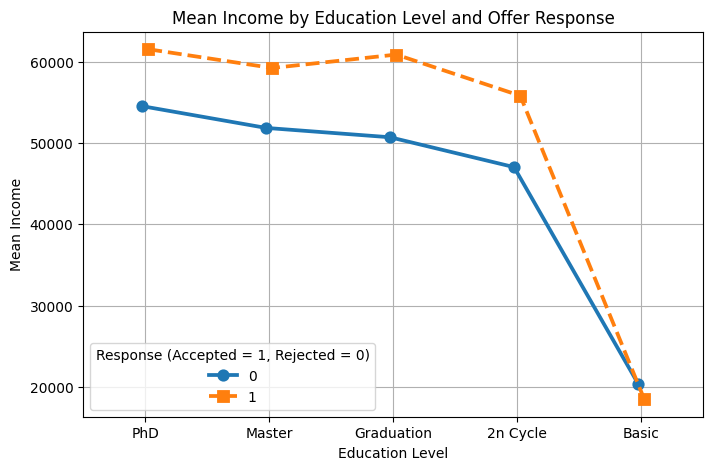

In [35]:
plt.figure(figsize=(8, 5))
sns.pointplot(data=DS3, x="Education", y="m", hue="Response", dodge=True, markers=["o", "s"], linestyles=["-", "--"])
plt.xlabel("Education Level")
plt.ylabel("Mean Income")
plt.title("Mean Income by Education Level and Offer Response")
plt.legend(title="Response (Accepted = 1, Rejected = 0)")
plt.grid()
plt.show()

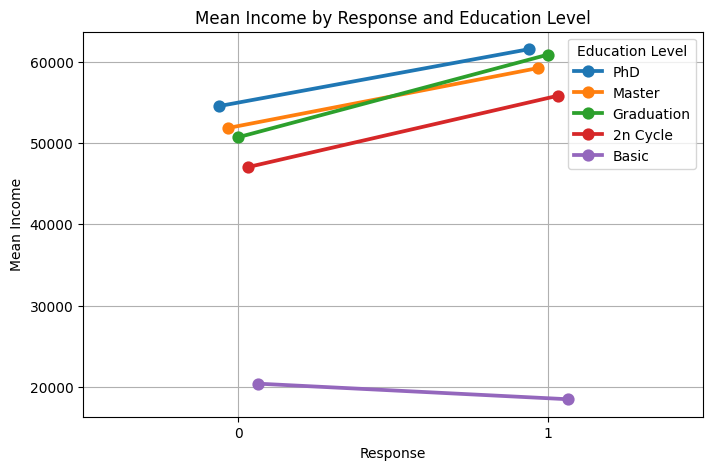

In [36]:
plt.figure(figsize=(8, 5))
sns.pointplot(data=DS3, x="Response", y="m", hue="Education", dodge=True, markers="o", linestyles="-")
plt.xlabel("Response")
plt.ylabel("Mean Income")
plt.title("Mean Income by Response and Education Level")
plt.legend(title="Education Level")
plt.grid()
plt.show()


If there were no interaction between Response and Education, we would expect all lines to be parallel in the first plot and all to show a positive trend in the second plot.

However, customers with a 'Basic' education break this pattern, causing the lines to cross or follow different directions. This suggests an interaction between Education and Response, meaning that the effect of one factor on Income depends on the other.

This can be tested using a Two-Way ANOVA.

In [37]:
# Ajustar el model de regressió
mod3 = smf.ols("Income ~ C(Response)*C(Education)", data=markclean).fit()

# Aplicar ANOVA
anova_results = anova_lm(mod3)

# Mostrar resultats
print(anova_results)

                              df        sum_sq       mean_sq          F  \
C(Response)                  1.0  2.690818e+10  2.690818e+10  62.740852   
C(Education)                 4.0  5.975737e+10  1.493934e+10  34.833541   
C(Response):C(Education)     4.0  8.174375e+08  2.043594e+08   0.476498   
Residual                  2230.0  9.563982e+11  4.288781e+08        NaN   

                                PR(>F)  
C(Response)               3.686486e-15  
C(Education)              2.984413e-28  
C(Response):C(Education)  7.530371e-01  
Residual                           NaN  


Based on the resulting p-values, it is safe to say that despite having main effects for each of the factors over the outcome (Income), there is nor eal interaction between them.

## Executive Summary

This study analyzes customer income levels and their likelihood of accepting the latest promotional offer based on various characteristics. The key findings are summarized below:

The average customer income is approximately 51,947. However, this should be interpreted with caution, as the distribution is skewed to the right due to a few customers with very high incomes.
Customers with a Basic education level tend to have lower average incomes compared to those with higher education levels.
A more detailed analysis shows that customers with a 2nd Cycle or Graduation level also have significantly different income levels compared to those with a PhD.
Higher-income customers tend to purchase fewer discounted products and visit the website less frequently.
Customers are more likely to accept the latest offer if they have previously accepted other promotional offers, made more discounted purchases, or visited the website more frequently in the last month.
Income is influenced by both education level and offer acceptance. However, there is no significant interaction between these two factors in explaining income.
These insights can help refine marketing strategies by identifying customer segments based on income and purchasing behavior.